In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
from mpmath import quad, npdf
import mpmath as mp
import matplotlib.cm as cm
from numpy import fft
from scipy.interpolate import interp1d
from source import plots
mp.dps = 10

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def gaussian_mean(M, r, a=77.4, b=0.87, c=-0.23, fsusy=1):
    """Return mean of conditional luminosity distribution.
    
    Inputs:
        - M: mass of subhalo [solar masses]
        - r: distance from galactic center [kpc]
        - a: coefficient for first term [default=77.4]
        - b: coefficient for second term [default=0.97]
        - c: coefficient for third term [default=-0.23]
        - fsusy: value of fsusy [default=1e-28 [cm**3 s**-1 GeV**-2]]
        
    Returns:
        - mean of the gaussian distribution
    """
    return a + b * np.log(M / 1e5) + c * np.log(r / 50) #+ np.log(fsusy)


def gaussian_sd(M, r, a=0.74, b=-0.003, c=0.011):
    """Return the sd of the conditional luminosity function.
    
    Inputs:
        - M: mass of subhalo [solar masses]
        - r: distance from galactic center [kpc]
        - a: coefficient for first term [default=0.74]
        - b: coefficient for second term [default=-0.003]
        - c: coefficient for third term [default=-0.011]
    
    Returns:
        - sd of gaussian
    """
    return a + b * np.log(M / 1e5) + c * np.log(r / 50)


def conditional_luminosity_function(lnL, M, r, mean_params={}, sd_params={}):
    """Gives the value of the conditional luminosity function.
    
    Inputs:
        - lnL: natural log of lumionsity of the subhalo
        - M: mass of the subhalo [solar masses]
        - r: galactocentric radius of the subhalo [kpc]
        - mean_params: coefficients for parameter dependence for the distribution mean
        - sd_params: coefficients for parameter dependence for the sd of the distribution
        
    Returns:
        - value of the clf
    """
    mean = gaussian_mean(M, r, **mean_params)
    sigma = gaussian_sd(M, r, **sd_params)
    
#     return stats.norm.pdf(lnL, loc=mean, scale=sigma)
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-1/2 * (lnL - mean)**2/sigma**2)


def mass_distribution(M, r, A=1.2e4, beta=1.9, rs=21):
    """Return the mass distribution value.
    
    Inputs:
        - M: mass of the subhalo [solar masses]
        - r: galactocentric radius of the subhalo [kpc]
        - A: amplitude [default=1.2e4 [solar mass**-1 kpc**-3]]
        - beta: strength of dependence on mass [default value=1.9]
        - rs: scale radius of Milky Way [default value=21 [kpc]]
        
    Returns:
        - value of mass distribution
    """
    r_tilde = r / rs
    
    return A * M**(-beta) / (r_tilde * (1 + r_tilde)**2)


def p1(F, psi, num=100, R_G=220, M_min=0.01, M_max=1e10, d_solar=8.5, mean_params={}, sd_params={}):
    """Return the unnormalized value of the probability distribution of one subhalo.
    
    Inputs:
        - F: flux of subhalo [photons/beam/year]
        - psi: angle from galactic center [degrees]
        - R_G: extent of dm halo [default value=220 [kpc]]
        - M_min: lower limit on mass integral [default=0.01 [solar masses]]
        - M_max: upper limit on mass integral [default=1e10 [solar masses]]
        - d_solar: galactocentric distance of sun [default=8.5 [kpc]]
        - mean_params: coefficients for parameter dependence for the distribution mean
        - sd_params: coefficients for parameter dependence for the sd of the distribution
        
    Returns:
        - value of probability of one subhalo for a given flux and angle
    """
    # Get upper bound for l integral
    psi_rad = np.deg2rad(psi)
    l_max = d_solar * (np.cos(psi_rad) + np.sqrt(-(np.sin(psi_rad)**2) + (R_G/d_solar)**2))
    
    # Convert years to seconds
    seconds_in_a_year = 3.154e7
    
    # Convert cm to kpc
    cm_in_a_kpc = 3.086e21
    
    def integrand_2d(M, l):
        # Luminosity
        Lsh = 4 * np.pi * l**2 * F / seconds_in_a_year / 2000 * cm_in_a_kpc**2
        
        # radius from GC
        r = np.sqrt(l**2 + d_solar**2 - 2*l*d_solar*np.cos(psi_rad))
#         print('mass dist', mass_distribution(M, r))
#         print('L', Lsh)
#         print('cond lum fun', conditional_luminosity_function(np.log(Lsh), M, r, mean_params=mean_params, sd_params=sd_params))
        return l**4 * mass_distribution(M, r) / Lsh * conditional_luminosity_function(np.log(Lsh), M, r, mean_params=mean_params, sd_params=sd_params)
#         return conditional_luminosity_function(np.log(Lsh), M, r, mean_params=mean_params, sd_params=sd_params)
    
    lvals = np.logspace(np.log10(1e-10), np.log10(l_max), num=num)
    mvals = np.logspace(np.log10(M_min), np.log10(M_max), num=num )
#     print('mass dist', np.trapz(np.trapz(conditional_luminosity_function)))
    func = integrand_2d(mvals[:, np.newaxis, np.newaxis], lvals[:, np.newaxis])
    int_exp2d = np.trapz(np.trapz(func, mvals, axis=0), lvals, axis=0)
    
    return int_exp2d


def mu(psi, R_G=220, M_min=0.01, M_max=1e10, d_solar=8.5, omega_pixel=(np.pi/180)**2, num=100):
    """Compute mean value of subhalos in a pixel."""
    # Get upper bound for l integral
    psi_rad = np.deg2rad(psi)
    l_max = d_solar * (np.cos(psi_rad) + np.sqrt(-(np.sin(psi_rad)**2) + (R_G/d_solar)**2))
    
    def integrand_2d(M, l):
        # radius from GC
        r = np.sqrt(l**2 + d_solar**2 - 2*l*d_solar*np.cos(psi_rad))
        
        return l**2 * mass_distribution(M, r)

    lvals = np.logspace(np.log10(1e-10), np.log10(l_max), num=num)
    mvals = np.logspace(np.log10(M_min), np.log10(M_max), num=num)
    
    # perform the 2d integration by first integrating of mass than luminosity
    int_exp2d = np.trapz(np.trapz(integrand_2d(mvals[:, np.newaxis, np.newaxis],lvals[:, np.newaxis]), mvals, axis=0), lvals, axis=0)
    
    return omega_pixel * int_exp2d
    
    
# def integral_2d(func, y, x, num=100):
#     """Return discrete 2d integral of the function over the arrays x & y."""
    

def psh(psi, F_min=1e-20, F_max=1, num_points=2**7):
    """Return the function P_sh(F) for a given psi.
    
    Inputs:
        - psi: angle from galactic center [degrees]
        - F_min: minimum flux for FFT
        - F_max: maximum flux for FFT
        - num_bins: number of points to perform FFT (power of 2 for speed)
        
    Returns:
        - function of probability distribution psh at psi
    """
    F = np.logspace(np.log10(F_min), np.log10(F_max), num=num_points)
    p1_vals = (p1_unnorm := p1(F, psi))/integrate.simps(p1_unnorm, F)
    
    func = fft.ifft(np.exp(mu(psi) * (fft.fft(p1_vals) - 1)))
    
    psh_func = interp1d(F, func)
    return psh_func
    

In [3]:
flux = 1e-6
flux * p1(flux, 40, M_max=1e10)


array([5.00326066e-26])

slope near end for n=-1: -3.0181163368557034
slope near end for n=0: -0.04478488209404263
slope near end for n=2: -0.0018174163735440304
slope near end for n=4: -0.0004839719080358532


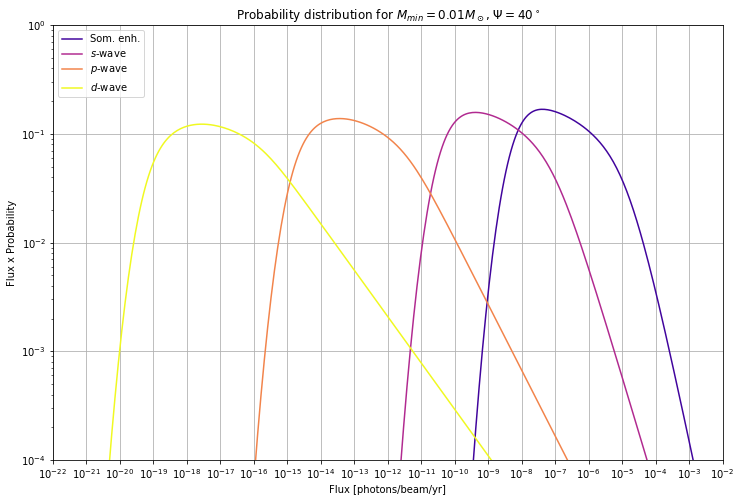

In [4]:
plt.close()

fig, ax = plt.subplots(figsize=(12, 8))
n_list = [-1, 0, 2, 4]
n_labels = {-1:"Som. enh.", 0: r"$s$-wave", 2:r"$p$-wave", 4:r"$d$-wave"}
colors = iter(cm.plasma(np.linspace(0.1, 1, num=len(n_list))))

for n in n_list:
    mean_params = {'a':77.4, 'b':0.87+0.31*n, 'c':-0.23-0.04*n}
    logmin = -22
    logmax = -1
    fluxes = np.logspace(logmin, logmax, num=(logmax-logmin)*20)
    probs = p1(fluxes, 40, mean_params=mean_params, num=200)
    # probs = [p1(flux, 40) for flux in fluxes]
    normalization = np.trapz(probs, fluxes)
    func = fluxes*probs/normalization
#     print(normalization)

    ax.plot(fluxes, func, label=n_labels[n], color=next(colors))
    print(f'slope near end for n={n}: {(func[-60]-func[-40])/(fluxes[-60]-fluxes[-40])}')

ax.set_xscale('log')
ax.set_xlabel('Flux [photons/beam/yr]')
ax.set_ylabel('Flux x Probability')
ax.set_yscale('log')
ax.set_ylim(bottom=1e-4, top=1)
ax.set_xlim(left=1e-22, right=1e-2)

ax.set_title(r"Probability distribution for $M_{min}=0.01 M_\odot$, $\Psi=40^\circ$")

# fluxes = np.logspace(-15, -3, num=25)
# # probs = p1(fluxes, 40, M_min=1e-6)
# probs = [p1(flux, 40, M_min=1e-6) for flux in fluxes]
# normalization = np.trapz(probs, fluxes)
# ax.plot(fluxes, fluxes*probs/normalization, label=r"$M_{min}=10^{-6} M_\odot$", color="xkcd:robin's egg blue")

ax.legend(loc='upper left')
ax.grid()
ax.set_xticks([1e-22 * 10**i for i in range(21)]);

In [5]:
fig.savefig('eq4_w_vel_dep.png')

<ipython-input-6-02d0117cf17c>:14: RuntimeWarning: divide by zero encountered in log10
  func = np.log10(probs/normalization)
<ipython-input-6-02d0117cf17c>:18: RuntimeWarning: invalid value encountered in subtract
  ax.plot(fluxes[:-1], (func[:-1]-func[1:])/(np.log10(fluxes[:-1])-np.log10(fluxes[1:])), label=n_labels[n], color=col)


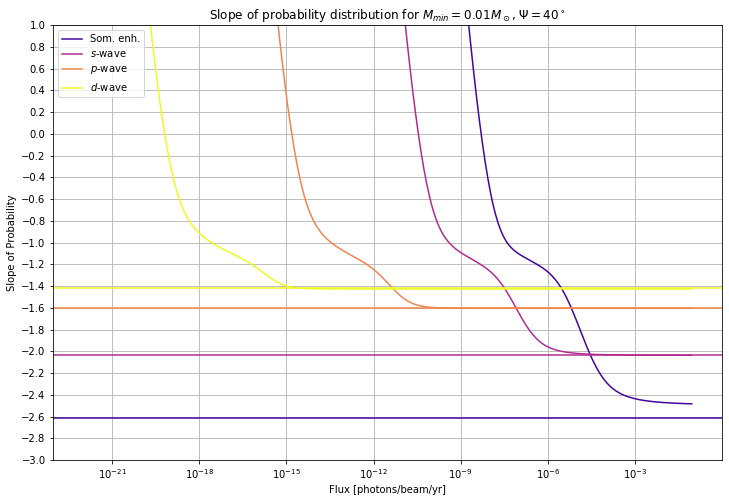

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))
n_list = [-1, 0, 2, 4]
n_labels = {-1:"Som. enh.", 0: r"$s$-wave", 2:r"$p$-wave", 4:r"$d$-wave"}
colors = iter(cm.plasma(np.linspace(0.1, 1, num=len(n_list))))

for n in n_list:
    mean_params = {'a':77.4, 'b':0.87+0.31*n, 'c':-0.23-0.04*n}
    logmin = -22
    logmax = -1
    fluxes = np.logspace(logmin, logmax, num=(logmax-logmin)*20)
    probs = p1(fluxes, 40, mean_params=mean_params, num=200)
    # probs = [p1(flux, 40) for flux in fluxes]
    normalization = np.trapz(probs, fluxes)
    func = np.log10(probs/normalization)
#     print(normalization)
    col = next(colors)

    ax.plot(fluxes[:-1], (func[:-1]-func[1:])/(np.log10(fluxes[:-1])-np.log10(fluxes[1:])), label=n_labels[n], color=col)
    ax.axhline(-1.03/(1+.36*n)-1, color=col)
#     print(f'slope near end for n={n}: {(func[-60]-func[-40])/(fluxes[-60]-fluxes[-40])}')
# 
ax.set_xscale('log')
ax.set_xlabel('Flux [photons/beam/yr]')
ax.set_ylabel('Slope of Probability')
# ax.set_yscale('log')
ax.set_ylim(bottom=-3, top=1)
# ax.set_xlim(left=1e-22, right=1e-2)

ax.set_title(r"Slope of probability distribution for $M_{min}=0.01 M_\odot$, $\Psi=40^\circ$")

# fluxes = np.logspace(-15, -3, num=25)
# # probs = p1(fluxes, 40, M_min=1e-6)
# probs = [p1(flux, 40, M_min=1e-6) for flux in fluxes]
# normalization = np.trapz(probs, fluxes)
# ax.plot(fluxes, fluxes*probs/normalization, label=r"$M_{min}=10^{-6} M_\odot$", color="xkcd:robin's egg blue")

ax.legend(loc='upper left')
ax.set_yticks(np.linspace(-3, 1, num=21))
ax.grid(which='both')

In [7]:
import astropy.table as table
from astropy.io import fits
fermi_bkgs = table.Table.read('/Users/runburg/Downloads/gll_iem_v07.fits')
catalog = fits.open("/Users/runburg/Downloads/gll_iem_v07.fits", memmap=True)

In [8]:
catalog.info

<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x1287daa30>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x128942610>]>

In [9]:
[mu(psi) for psi in np.linspace(30, 90, num=7)]

[array([5498279.13535018]),
 array([5053770.34137904]),
 array([4665344.47545406]),
 array([4321818.63868572]),
 array([4017713.02170248]),
 array([3749572.8270655]),
 array([3514749.91955049])]

In [10]:
catalog[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 2880                                                  
NAXIS2  =                 1441                                                  
NAXIS3  =                   28                                                  
EXTEND  =                    T                                                  
CRVAL1  =                    0                                                  
CDELT1  =               -0.125                                                  
CRPIX1  =               1440.5                                                  
CTYPE1  = 'GLON-CAR'                                                            
CUNIT1  = 'deg     '                                                            
CRVAL2  =                   

In [11]:
table.Table.read(catalog[1])

energy
MeV
float64
49.99999999999999
64.98283000000002
84.45536389617803
109.7629710930695
142.65416981671697
185.40143331981702
240.95819646356009
313.1629103579625


In [12]:
psi = 40
num = 5000
F = np.logspace(-15, 0, num=num)
muu = mu(psi) * integrate.simps(F*p1(F, psi), F), integrate.simps(F*psh(psi)(F), F)

<ipython-input-2-5f495ebb354e>:162: RuntimeWarning: overflow encountered in exp
  func = fft.ifft(np.exp(mu(psi) * (fft.fft(p1_vals) - 1)))


Text(0, 0.5, '$\\mu$($\\Psi$)')

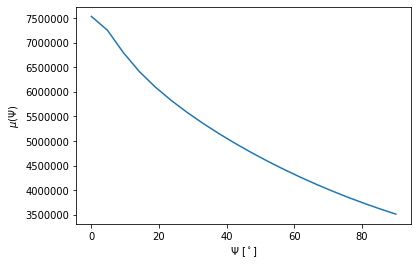

In [13]:
fig, ax = plt.subplots()
psis = np.linspace(0, 90, num=20)
ax.plot(psis, [mu(pssi) for pssi in psis])
ax.set_xlabel(r'$\Psi$ [$^\circ$]')
ax.set_ylabel(r'$\mu$($\Psi$)')

In [14]:
np.exp(1e2)

2.6881171418161356e+43

In [15]:
mu(40)[0], mu(60)[0], mu(80)[0]

(5053770.341379036, 4321818.638685722, 3749572.827065499)

In [69]:
R_G = 220 # Kpc
d_sun = 8.5 # kpc
psi = 60
M_min = 1.0e-2 # Msun
M_max = 1.0e10 # Msun
fwimp = 1.0
nside_map = 2048
mean_params = {}
sd_params = {}
omega_pixel = 4.*np.pi/(12*nside_map**2.) # sr
area_fermi = 2000.0 # cm^2
N = 5000
log_flux_min = -15 # log10 photons/cm^2/yr
log_flux_max = -5 # log10 photons/cm^2/yr
log_k_min = -7
log_k_max = 9
N_k = 60000
psh_log_f_min = -8
psh_log_f_max = -4
N_psh = 1000



muu = mu(psi, R_G=R_G, M_min=M_min, M_max=M_max, d_solar=d_sun, omega_pixel=omega_pixel, num=500)
# muu = 3987.87
print(muu)

[3411.58593004]


In [70]:
N = 5000
# psi = 40
fluxes = np.logspace(-15+np.log10(2000), -5+np.log10(2000), num=N)

# p11 = np.array([p1(flux, psi, num=50)[0] for flux in fluxes])
# print(p11.shape, fluxes.shape)
# p11 /= integrate.simps(p11, fluxes)
p1_vals = p1(fluxes, psi, num=100, mean_params={}, sd_params={})
# print(p1_vals)
fluxes /= 2000
p1_vals /= np.trapz(p1_vals, fluxes)

# k = np.flip(1/fluxes)
# k = 1/fluxes
# len(p1_vals), len(fluxes), p1_vals

integral: 0.00011630618862182764


(1e-16, 1e-05)

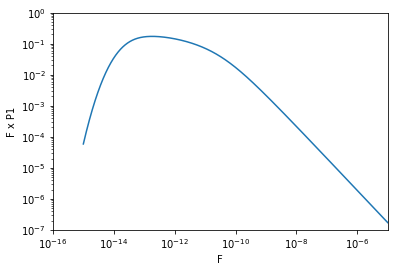

In [71]:
print(f'integral: {(mu(psi) * np.trapz(fluxes * p1_vals, fluxes))[0]}')

fig, axs = plt.subplots()
i = 0
axs.plot(fluxes[i:], fluxes[i:] * p1_vals[i:])
# axs.plot(fluxes, fluxes * p11 * mu(psi))
axs.set_xscale('log')
axs.set_yscale('log')
# axs.set_xlim(left=1e-22, right=1e-2)
axs.set_ylabel('F x P1')
axs.set_xlabel('F')
axs.set_ylim(bottom=1e-7, top=1)
axs.set_xlim(left=1e-16, right=1e-5)


# np.sum(p1_vals < 0)

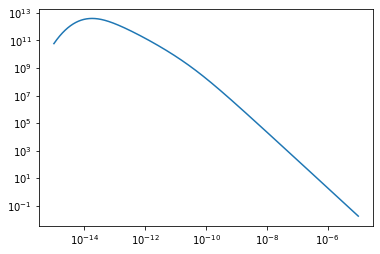

In [72]:
fig, ax = plt.subplots()
ax.plot(fluxes, p1_vals)
ax.set_xscale('log')
ax.set_yscale('log')

In [107]:
# k = np.concatenate((-1/fluxes, np.flip(1/fluxes)))
k = np.logspace(3, 9, num=60000)
# k = np.flip(1/fluxes)
func = p1_vals * np.exp(2j * np.pi * fluxes * k[:, np.newaxis])
# func = p1_vals * np.cos(-2 * np.pi * fluxes * k[:, np.newaxis])
ft_p1 = integrate.simps(func, fluxes, axis=1)

Text(0, 0.5, 'P1(k)')

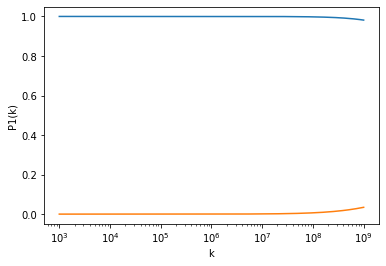

In [108]:
fig, ax = plt.subplots()
ax.plot(k, ft_p1.real)
ax.plot(k, ft_p1.imag)
ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(bottom=1e-20)
ax.set_xlabel('k')
ax.set_ylabel('P1(k)')

Text(0.5, 1.0, 'exp(mu(P1(k) - 1))')

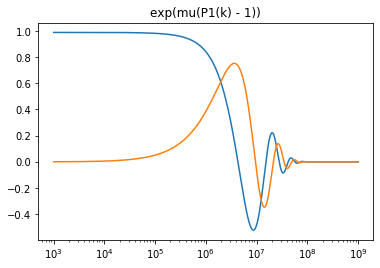

In [109]:
fig, ax = plt.subplots()
ax.plot(k, np.exp(muu * (ft_p1 - 1)).real)
ax.plot(k, np.exp(muu * (ft_p1 - 1)).imag)
# ax.plot(k, ft_p1.imag)
ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(bottom=1e-30)
ax.set_title('exp(mu(P1(k) - 1))')

In [110]:
ks = np.concatenate((-np.flip(k), k))
ft_p1s = np.concatenate((np.conj(np.flip(ft_p1)), ft_p1))
fluxess = np.logspace(-8, -4, num=1000)
# print(ft_p1.shape, eval_pts.shape, (fluxes[:, np.newaxis, np.newaxis]*k).shape, k.shape)
func = np.exp(muu * (ft_p1s - 1)) * np.exp(-2j * np.pi * fluxess[:, np.newaxis] * ks)
print(func.shape)
ift_func = np.trapz(func, ks, axis=1)
# print(ift_func)
# print((ift_func*eval_pts.T).shape)
pf = ift_func

(1000, 120000)


/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


\mu \int F P1: [9.18102595e-08]
 \int F Psh: 9.025261419132454e-08
1.596626022101425e-05


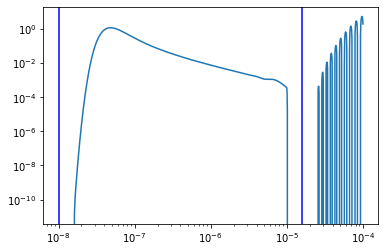

In [123]:
plt.plot(fluxess, fluxess * ift_func)
ax = plt.gca()
startl = 0
limi = -200
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(fluxess[startl], color='b')
ax.axvline(fluxess[limi], color='b')

ax.axvline()



print(f'\mu \int F P1: {(muu * integrate.simps(fluxes * p1_vals, fluxes))}')
print(f' \int F Psh: {integrate.simps(pf[startl:limi].real * fluxess[startl:limi], fluxess[startl:limi])}')
print(fluxess[limi])

In [124]:
9.041374192727713e-08

9.041374192727713e-08

In [181]:
n = 0
params = {'R_G': 220, # Kpc
          'd_solar': 8.5, # kpc
          'psi': 80,
          'M_min': 1.0e-2, # Msun
          'M_max': 1.0e10, # Msun
          'fwimp': 1.0,
          'mean_params': {'a':77.4, 'b':0.87+0.31*n, 'c':-0.23-0.04*n},
          'nside': 2048,
          'area_fermi': 2000.0, # cm^2
          'n': n,
          'log_flux_min': -15, # log10 photons/cm^2/yr
          'log_flux_max': -7, # log10 photons/cm^2/yr
          'N': 10000,
          'log_k_min': 3,
          'log_k_max': 9,
          'N_k': 10000,
          'psh_log_f_min': -8,
          'psh_log_f_max': -6,
          'N_psh': 500
         }

params['omega_pixel'] = 4.*np.pi/(12*params['nside']**2.) # sr
p = params

In [182]:
import source.prob_dists as pd
import importlib
importlib.reload(pd)
importlib.reload(plots)

<module 'source.plots' from '/Users/runburg/github/dm_gal_substructure/source/plots.py'>

Got P1(F) values
inferred log_k_max 8.500000000000018
Finished FT of P1
133
Finished Psh computation
\mu \int F P1: [4.63011693e-08]
 \int F Psh: 4.622144242502742e-08


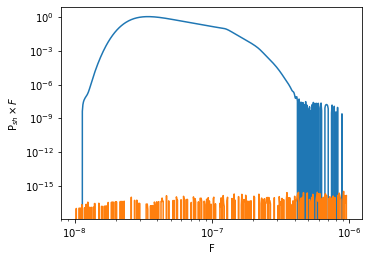

In [159]:
pshvals, fxs = pd.psh(params, plot=True, infer_values=True)

 \int F Psh: 4.6220781905101027e-08


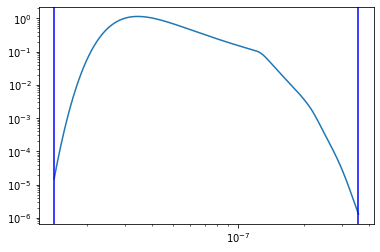

In [160]:
plt.plot(fxs, fxs * pshvals.real)
ax = plt.gca()
startl = 0
limi = -1
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(fxs[startl], color='b')
ax.axvline(fxs[limi], color='b')

print(f' \int F Psh: {integrate.simps(pshvals[startl:limi].real * fxs[startl:limi], fxs[startl:limi])}')


Angle: 40.0
Got P1(F) values
inferred log_k_max 8.500000000000018
Finished FT of P1
Finished Psh computation
\mu \int F P1: 9.922695415554573e-08
 \int F Psh: 9.89964534857742e-08
percent error = -0.23%

Angle: 52.5
Got P1(F) values
inferred log_k_max 8.500000000000018
Finished FT of P1
Finished Psh computation
\mu \int F P1: 7.467021623214654e-08
 \int F Psh: 7.451319819933172e-08
percent error = -0.21%

Angle: 65.0
Got P1(F) values
inferred log_k_max 8.500000000000018
Finished FT of P1
Finished Psh computation
\mu \int F P1: 5.881802098863501e-08
 \int F Psh: 5.8705468681849656e-08
percent error = -0.19%

Angle: 77.5
Got P1(F) values
inferred log_k_max 8.500000000000018
Finished FT of P1
Finished Psh computation
\mu \int F P1: 4.8032675493536124e-08
 \int F Psh: 4.794855136674891e-08
percent error = -0.18%

Angle: 90.0
Got P1(F) values
inferred log_k_max 9.000000000000018
Finished FT of P1
Finished Psh computation
\mu \int F P1: 4.044169009246113e-08
 \int F Psh: 4.037643404934788e-0

[Text(1, 0, '40.0'),
 Text(1, 0, '50.0'),
 Text(1, 0, '60.0'),
 Text(1, 0, '70.0'),
 Text(1, 0, '80.0'),
 Text(1, 0, '90.0')]

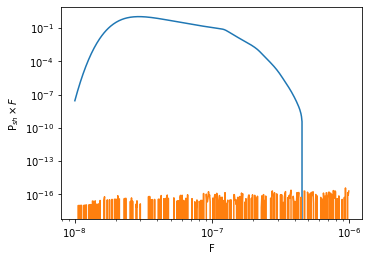

In [183]:
numnum = 5
psis = np.linspace(40, 90, num=numnum)
colors = cm.viridis(np.linspace(0, 1, num=numnum))

fig, ax = plt.subplots()

psh_vals_over_psi = []

for psi, col in zip(psis, colors):
    p['psi'] = psi
    print('Angle:', psi)
    pshvals, fxs = pd.psh(params, plot=True, infer_values=True)
    
    psh_vals_over_psi.append((pshvals, fxs))
    
    ax.plot(fxs, fxs * pshvals.real, label=rf"{psi}$^\circ$", color=col)
   
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('F')
ax.set_ylabel('F x Psh')
cbarlabs = np.arange(min(psis), max(psis)+1, step=10)
cbar = fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ticks=np.linspace(0, 1, num=len(cbarlabs)))
cbar.set_label(r'$\psi$[$^\circ$]', rotation=270)
cbar.ax.set_yticklabels(cbarlabs)

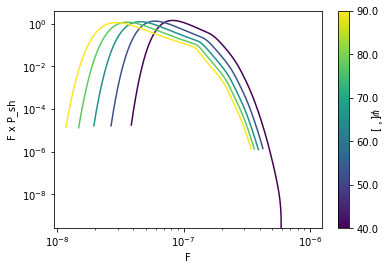

In [180]:
fig.savefig('./output/psh_n0.png')

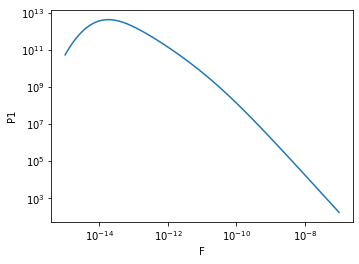

In [133]:
fluxes = np.logspace(p['log_flux_min'], p['log_flux_max'], num=p['N'])
p1_vals = pd.p1(fluxes, **p)
fig, _ = plots.check_p1_plot(fluxes, p1_vals)

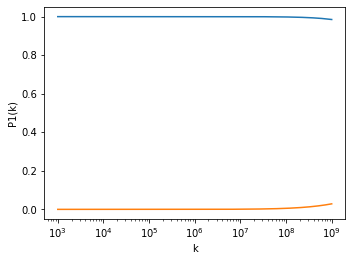

In [134]:
muu = pd.mu(**p)
ft_p1_vals, k = pd.ft_p1(p1_vals, fluxes, **p)
fig, _ = plots.check_ft_p1_plot(k, ft_p1_vals)

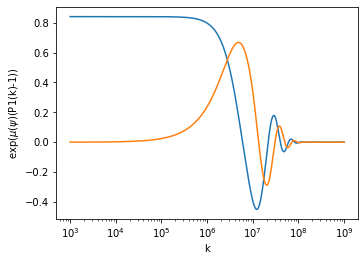

In [135]:
fig, _ = plots.check_psh_integrand_plot(k, ft_p1_vals, muu)


In [136]:
pf_vals, flux = pd.pf(muu, ft_p1_vals, k, **p)

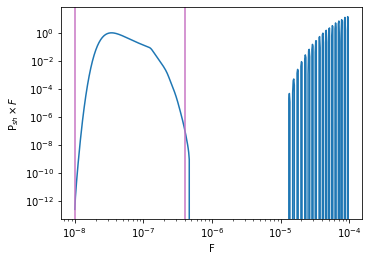

In [143]:
startl = 0
limi = -300
fig, _ = plots.check_psh_plot(flux, pf_vals.real, j=[startl, limi])

# print(pf_vals)

In [144]:
print(f'\mu \int F P1: {(muu * integrate.simps(fluxes * p1_vals, fluxes))}')
print(f' \int F Psh: {integrate.simps(pf_vals[startl:limi].real * flux[startl:limi], flux[startl:limi])}')



\mu \int F P1: [4.62985523e-08]
 \int F Psh: 3.890234477999541e-08


In [113]:
good_psh = pf[startl:limi].real
good_flux = fluxess[startl:limi]

NameError: name 'pf' is not defined

In [ ]:
import healpy

mview = healpy.mollview(m, )

In [25]:
## mean = mu(psi)
sd = np.sqrt(mean)
print(mean, '+/-', sd)
# gauss = stats.norm.pdf(, mean, sd)
eval_pts = np.linspace(mean - 5 * sd, mean + 5 * sd, num=100)
# # # print(np.exp(2j * np.pi * fluxes[:, np.newaxis] * k).shape, (ft_p1**eval_pts).shape)
# # print((np.exp(2j * np.pi * fluxes[:, np.newaxis, np.newaxis] * k)* ft_p1**eval_pts).shape)
# fluxes *= 1e4
ks = np.concatenate((-np.flip(k), k))
ft_p1s = np.concatenate((np.conj(np.flip(ft_p1)), ft_p1))
fluxess = np.logspace(-1, 1, num=100)
# print(ft_p1.shape, eval_pts.shape, (fluxes[:, np.newaxis, np.newaxis]*k).shape, k.shape)
func = ft_p1s**eval_pts * np.exp(2j * np.pi * fluxess[:, np.newaxis, np.newaxis] * ks)

ift_func = np.trapz(func, ks, axis=2)
# print(ift_func)
# print((ift_func*eval_pts.T).shape)
pf = np.trapz(ift_func * stats.norm.pdf(eval_pts, mean, sd).T, eval_pts.T, axis=1)
max(pf)

NameError: name 'mean' is not defined

In [ ]:
fig, ax = plt.subplots()
start = 0
end = -1
# print(pf)
# end = (N*800)//1000
ax.plot(fluxess[start:end], pf[start:end].real)
ax.plot(fluxess[start:end], pf[start:end].imag)
startl = 22
limi = -7
ax.axvline(fluxess[startl], c='b')
ax.axvline(fluxess[limi], c='b')
# print(pf.imag)
# print(pf[:100])
ax.set_xscale('log')
# fluxes
ax.set_xscale('log')
ax.set_xlabel('Flux')
ax.set_ylabel('P(F)')
ax.set_yscale('log')
# ax.set_ylim(bottom=1e-3, top=1)
# ax.set_xlim(right=2)
# print(fluxes[800:900])

In [ ]:
print(f'\mu \int F P1: {(mu(psi) * integrate.simps(fluxes * p1_vals, fluxes))[0]}')
print(f' \int F Psh: {integrate.simps(pf[startl:limi].real * fluxess[startl:limi], fluxess[startl:limi])}')

In [ ]:
(1+5e-6j)**1000000

In [ ]:
# N=30000, bounds = (-50, 10)
0.4292
0.5223


# N=30000, bounds=(-40, 10)
0.43555429045193855
Out[344]:
0.5222704904370656

0.41764269656926734
Out[157]:
0.5495383367409762

0.4056755684464056
Out[100]:
0.5462375569916547

In [ ]:
fig, ax = plt.subplots()
ax.plot(fluxes, p1_vals)
ax.set_xscale('log')
# fluxes
ax.set_xscale('log')
ax.set_xlabel('Flux')
ax.set_ylabel('P(F)')
ax.set_yscale('log')

In [ ]:
funcinv = ft_p1 * np.exp(2j * np.pi * fluxes[:, np.newaxis] * k)
ft_p1inv = integrate.simps(funcinv, k, axis=1)
len(ft_p1), len(fluxes)
ft_p1inv

In [ ]:
fig, ax = plt.subplots()
ax.plot(fluxes, ft_p1inv)
ax.plot(fluxes, p1_vals)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(left=1e-16, right=1)

In [ ]:
psi = 40
poisson = lambda F: stats.poisson.pmf(F, mu(psi))
epsilon = 1e-10
pf = poisson(0) + poisson(1) * p1_vals

In [ ]:
print('max k', mu(psi))
maxk = int(mu(psi) * 10)
for i in range(2, maxk):
    func = ft_p1**i * np.exp(2j * np.pi * fluxes[:, np.newaxis] * k)
    ift_func = integrate.simps(func, k, axis=1)
#     print(ift_func.real)
    if i % 10000 == 0:
        print('completed', i, 'of', maxk)
    pf += poisson(i)*ift_func.real

mu*\int dF F*P_1(F) vs. \int dF F*P_sh(F)

In [ ]:
# fft.fft(p1_lin)

# fft.ifft(np.exp((fft.fft(p1_lin, norm='ortho') - 1)))[::num//10]

# norm_psh = integrate.simps(p_sh, fluxes)

# fig, ax = plt.subplots()
# ax.plot(fluxes, p_sh * fluxes / norm_psh, color='xkcd:bubblegum pink')
# ax.set_xscale('log')
# ax.set_xlabel('Flux')
# ax.set_ylabel('Flux x P_sh')

# import nfft

# psi = 40
# N = 10000
# fluxes = np.logspace(-20, 0, num=N//100)
# p1_vals = p1(fluxes, psi)
# # print(p1_vals[:])
# normalization = integrate.simps(p1_vals, fluxes) 
# p1_vals /= normalization

# f_k_direct = nfft.ndft_adjoint(fluxes, p1_vals, N)
# # # print(f_k_direct)
# # f_k_direct/1e8
# f_k_direct

# # nfft.ndft(fluxes, nfft.ndft_adjoint(fluxes, p1_vals, N))[::100], p1_vals[::100]

# import pyfftlog

# # angle in the sky
# psi = 40

# # number of points (max 4096)
# N = 2**10

# # bounds of interval log
# logfmin = -20
# logfmax = 1

# # k_c f_c (c is center point of array)
# kf = 1

# # order of bessel function
# mvu = 1/2

# # bias exponent
# q = 0

# # forward direction
# tdir = 1

# # Try to deal with any non-smoothness
# kropt = 1
